In [1]:
# Importamos todas las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score


### Carga de datos

In [2]:
# cargamos el csv como un datagrame
ruta='../data/train.csv'
df = pd.read_csv(filepath_or_buffer=ruta, sep=',')
df.shape

(1460, 81)

In [3]:
df.info() # obtenemos informacion del dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
df.isnull().sum() # verificamos si existen valores nulos

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

### Limpieza de Datos:
* Identificación y eliminación de valores duplicados: Asegúrate de que no haya registros duplicados que puedan sesgar los resultados del análisis.
* Verificación y ajuste de tipos de datos: Verifica que cada columna tenga el tipo de dato correcto (numérico o categórico) y ajusta si es necesario.
* Corrección de inconsistencias en valores categóricos: Revisa las categorías de las variables y unifica aquellos valores que puedan estar escritos de diferentes maneras pero que representen lo mismo.
* Manejo de valores faltantes adecuadamente: Identifica y maneja los valores faltantes utilizando técnicas apropiadas como la imputación de la mediana, media o moda, según corresponda.

In [5]:
# Verificamos la cantidad de registros duplicados
duplicados = df.duplicated().sum()
print(f'Número de registros duplicados: {duplicados}')

Número de registros duplicados: 0


In [6]:
# Lista de columnas a eliminar, para reducir la cantidad de columnas del dataframe
# estas columnas no aportan datos utiles para el tratamiento de los datos
columnas_a_eliminar = ['PoolQC','MiscFeature','Alley','Id','GarageYrBlt','BsmtFinSF2','1stFlrSF','Condition2','Utilities']

# Eliminar las columnas del DataFrame
df = df.drop(columns=columnas_a_eliminar)


In [7]:
# Verificamos los tipos de datos
print(df.dtypes)

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 72, dtype: object


In [8]:
# creo un diccionario con los tipos de datos
diccionario = df.dtypes.to_dict()
print(diccionario)

{'MSSubClass': dtype('int64'), 'MSZoning': dtype('O'), 'LotFrontage': dtype('float64'), 'LotArea': dtype('int64'), 'Street': dtype('O'), 'LotShape': dtype('O'), 'LandContour': dtype('O'), 'LotConfig': dtype('O'), 'LandSlope': dtype('O'), 'Neighborhood': dtype('O'), 'Condition1': dtype('O'), 'BldgType': dtype('O'), 'HouseStyle': dtype('O'), 'OverallQual': dtype('int64'), 'OverallCond': dtype('int64'), 'YearBuilt': dtype('int64'), 'YearRemodAdd': dtype('int64'), 'RoofStyle': dtype('O'), 'RoofMatl': dtype('O'), 'Exterior1st': dtype('O'), 'Exterior2nd': dtype('O'), 'MasVnrType': dtype('O'), 'MasVnrArea': dtype('float64'), 'ExterQual': dtype('O'), 'ExterCond': dtype('O'), 'Foundation': dtype('O'), 'BsmtQual': dtype('O'), 'BsmtCond': dtype('O'), 'BsmtExposure': dtype('O'), 'BsmtFinType1': dtype('O'), 'BsmtFinSF1': dtype('int64'), 'BsmtFinType2': dtype('O'), 'BsmtUnfSF': dtype('int64'), 'TotalBsmtSF': dtype('int64'), 'Heating': dtype('O'), 'HeatingQC': dtype('O'), 'CentralAir': dtype('O'), 'E

In [9]:
# creo una funcion para corregir los tipos de datos
def corregir_tipo():
    for columna, tipo in diccionario.items(): # ciclo para recorrer cada item del diccionario
        # verificamos el tipo de datos actual de la columna en el DataFrame
        tipo_actual = df[columna].dtype
        # comparamos el tipo actual con el tipo esperado
        if tipo_actual != tipo:  # si los tipos no coinciden, procedemos a corregir
            if tipo == 'datetime64[ns]':
                df[columna] = pd.to_datetime(df[columna], errors='coerce')
            elif tipo == 'object':
                df[columna] = df[columna].astype(str)
            else:
                df[columna] = df[columna].astype(tipo)
    df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).astype('category')

In [10]:
print(df.dtypes) # antes de la conversion

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 72, dtype: object


In [11]:
# ejecutamos la conversion
corregir_tipo() 
# Verificamos los tipos de datos despues de la correccion
print(df.dtypes)

MSSubClass          int64
MSZoning         category
LotFrontage       float64
LotArea             int64
Street           category
                   ...   
MoSold              int64
YrSold              int64
SaleType         category
SaleCondition    category
SalePrice           int64
Length: 72, dtype: object


In [12]:
# Identificar valores faltantes
valores_faltantes = df.isnull().sum()
print(valores_faltantes[valores_faltantes > 0])

LotFrontage      259
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
Fence           1179
dtype: int64


In [13]:
# definimos columnas numericas
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('Id', errors='ignore')
# definimos columnas categoricas
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
# mostramos las listas de columnas numericas y categoricas
print(categorical_cols)
print('')
print(numerical_cols)


Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'Ope

In [14]:
imputer = SimpleImputer(strategy='median')
# Imputar los valores faltantes en las columnas numéricas
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

In [15]:
imputer_cat = SimpleImputer(strategy='most_frequent')
# Imputar los valores faltantes en las columnas categóricas
df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

In [16]:
# Identificar valores faltantes
valores_faltantes = df.isnull().sum()
print(valores_faltantes[valores_faltantes > 0])

Series([], dtype: int64)


### Exploración de Datos:
* Visualizaciones univariadas y multivariadas: Crea histogramas, gráficos de barras, diagramas de dispersión y mapas de calor para entender la distribución y las relaciones entre las variables.
* Estadísticas descriptivas: Calcula medidas de tendencia central (media, mediana, moda) y de dispersión (rango, desviación estándar) para cada característica del dataset.

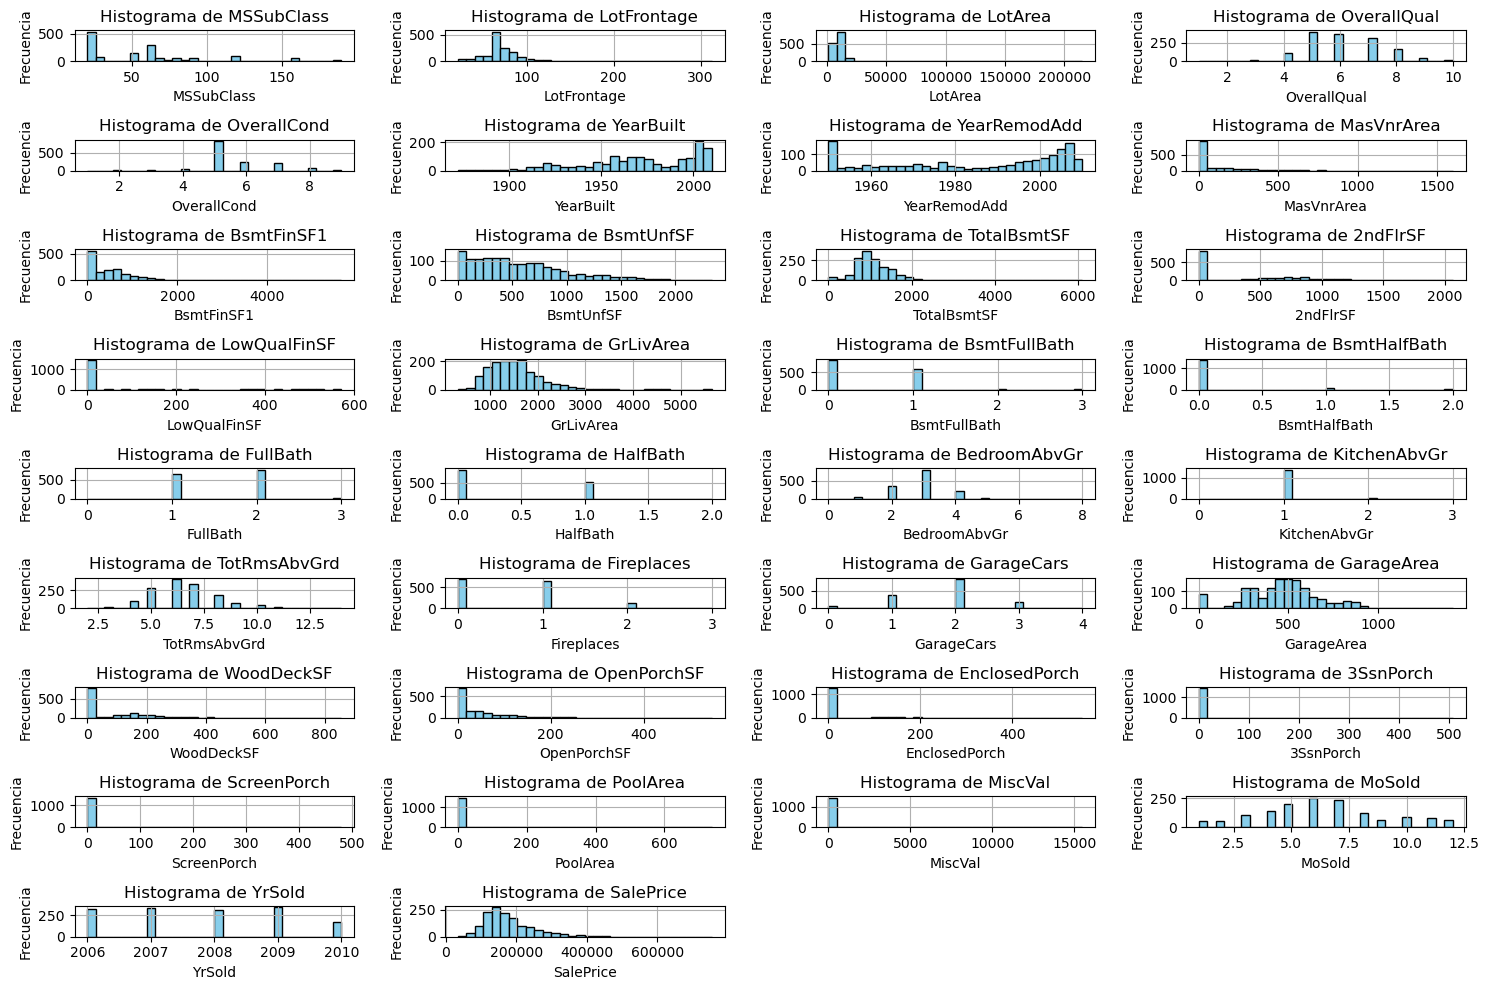

In [17]:
# Histograma para variables numéricas
plt.figure(figsize=(15, 10))  # establecemos el tamaño de la figura (ancho, alto)
num_plots = len(numerical_cols)  # contamos el número de columnas numéricas
num_rows = int(np.ceil(num_plots / 4))  #cCalculamos el número de filas necesarias para acomodar todos los histogramas (4 columnas por fila)

for i, col in enumerate(numerical_cols, 1):  # Iteramos sobre cada columna numérica y su índice
    plt.subplot(num_rows, 4, i)  # creamos una subgráfica en la posición (fila, columna)
    df[col].hist(bins=30, color='skyblue', edgecolor='black')  # dibujamos el histograma de la columna actual
    plt.title(f'Histograma de {col}')  # establecemos el título del histograma
    plt.xlabel(col)  # etiquetamos el eje x con el nombre de la columna
    plt.ylabel('Frecuencia')  # etiquetamos el eje y con 'Frecuencia'

plt.tight_layout()  # ajustamos la disposición de las subgráficas para que no se superpongan
plt.show() # mostramos la figura con todos los histogramas


/tmp/ipykernel_7657/897516970.py:13: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()  # Ajustamos la disposición de las subgráficas


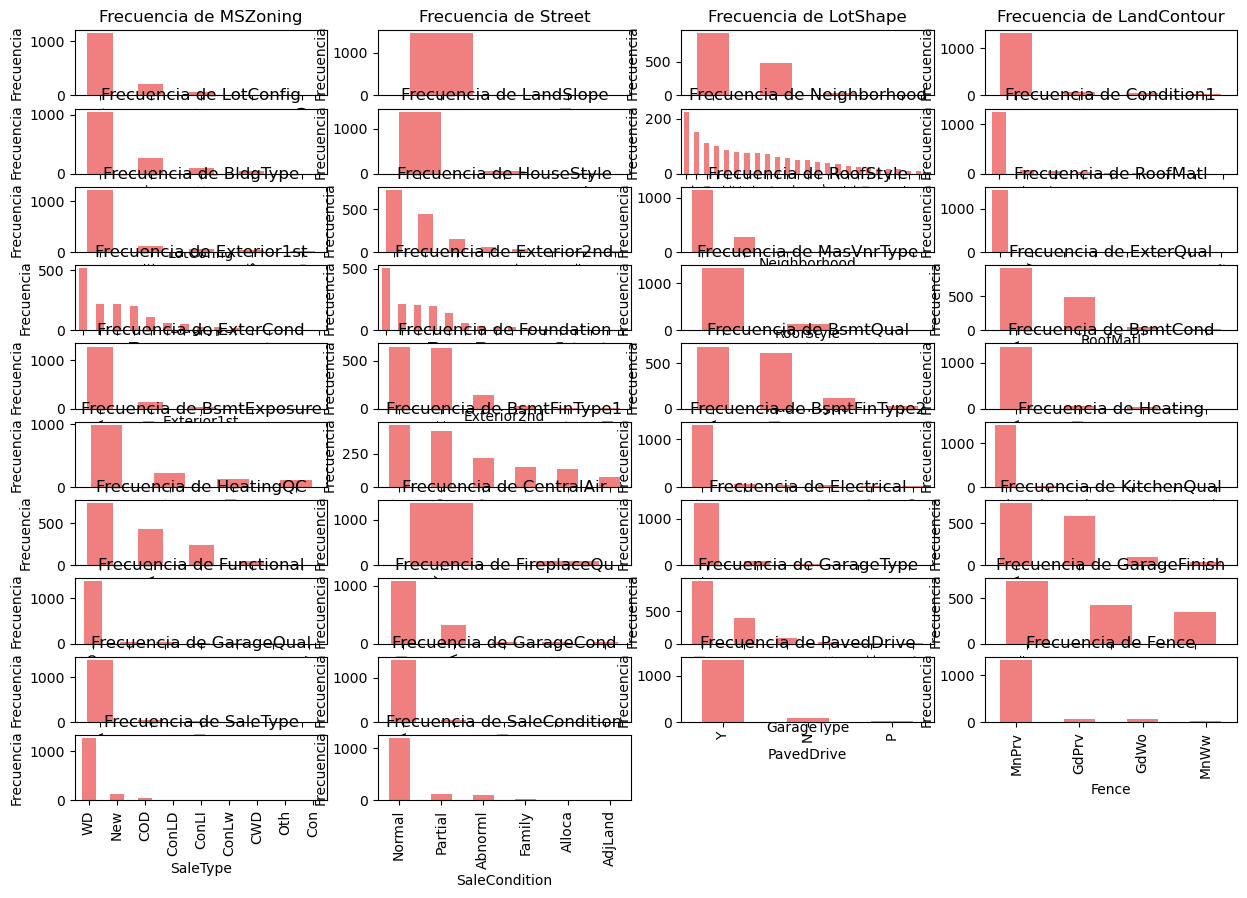

In [18]:
# Gráficos de barras para variables categóricas
plt.figure(figsize=(15, 10))  # Establecemos el tamaño de la figura (ancho, alto)
cat_plots = len(categorical_cols)  # Contamos el número de columnas categóricas
cat_rows = int(np.ceil(cat_plots / 4))  # Calculamos el número de filas necesarias para acomodar todos los gráficos (4 columnas por fila)

for i, col in enumerate(categorical_cols, 1):  # Iteramos sobre cada columna categórica y su índice
    plt.subplot(cat_rows, 4, i)  # Creamos una subgráfica en la posición (fila, columna)
    df[col].value_counts().plot(kind='bar', color='lightcoral')  # Contamos los valores únicos en la columna actual y los graficamos
    plt.title(f'Frecuencia de {col}')  # Establecemos el título del gráfico de barras
    plt.xlabel(col)  # Etiquetamos el eje x con el nombre de la columna
    plt.ylabel('Frecuencia')  # Etiquetamos el eje y con 'Frecuencia'

plt.tight_layout()  # Ajustamos la disposición de las subgráficas
plt.show()  # Mostramos

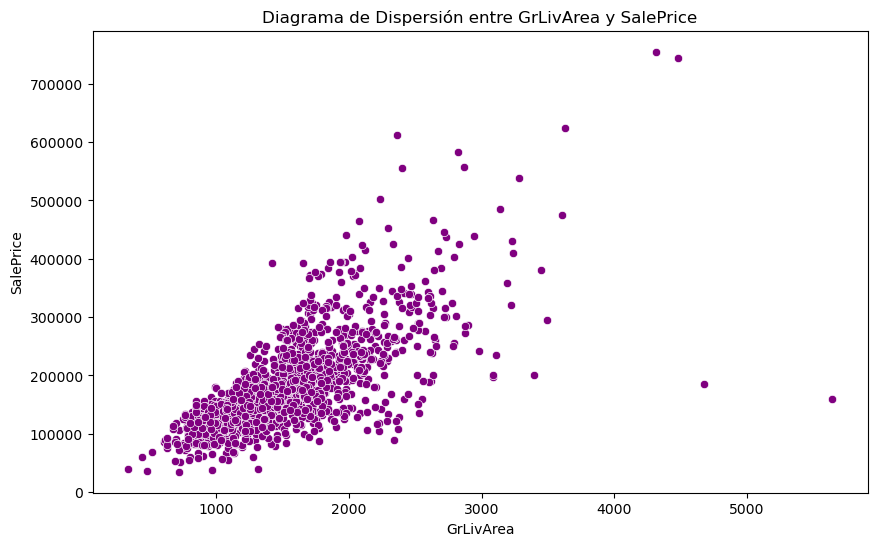

In [19]:
# Diagramas de dispersión
plt.figure(figsize=(10, 6))  # tamaño de la figura (ancho, alto)
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice', color='purple')  # diagrama de dispersión entre GrLivArea y SalePrice
plt.title('Diagrama de Dispersión entre GrLivArea y SalePrice')  # titulo del gráfico
plt.xlabel('GrLivArea')  # etiquetamos el eje x
plt.ylabel('SalePrice')  # etiquetamos el eje y
plt.show()  # visualizamos el gráfico

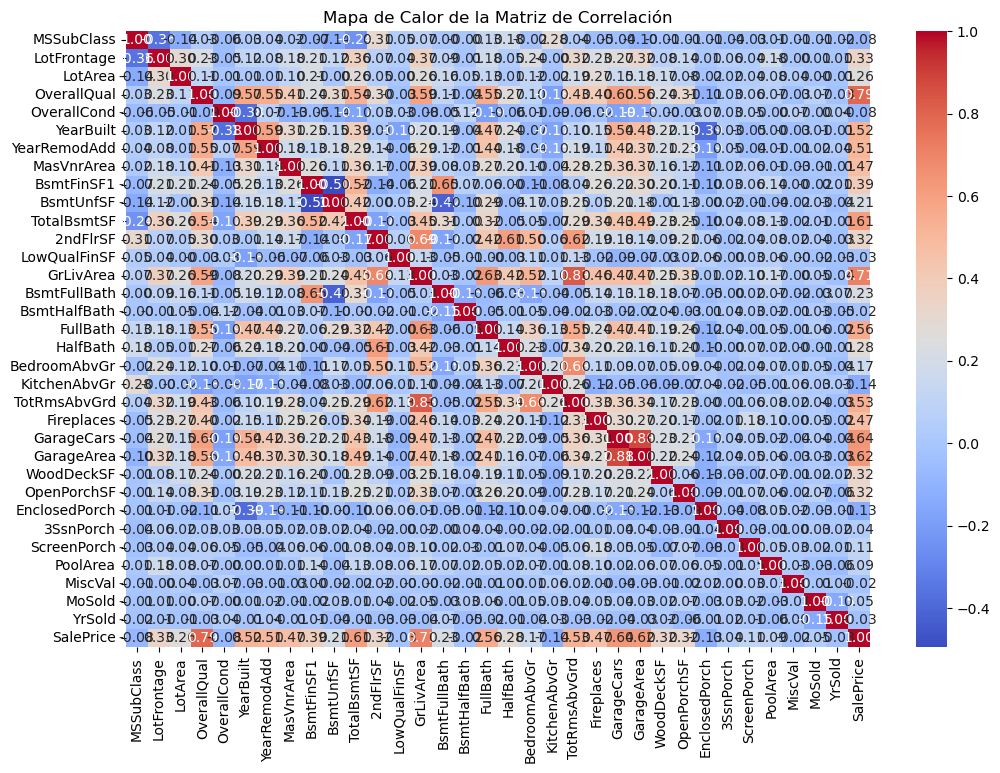

In [20]:
# Mapa de calor de correlación
correlation_matrix = df[numerical_cols].corr()  # solo para las columnas numéricas
plt.figure(figsize=(12, 8))  # tamaño de la figura (ancho, alto)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)  
plt.title('Mapa de Calor de la Matriz de Correlación')  # título del gráfico
plt.show()  # visualizamos el gráfico

In [21]:
# medidas de tendencia central y dispersión para variables numéricas
print("\nEstadísticas descriptivas para variables numéricas:")  # encabezado 
print(df[numerical_cols].describe())  # mostramos la estadísticas descriptivas

# medidas de tendencia central y dispersión por columna
for col in numerical_cols:  # Itera sobre cada columna numérica
    print(f"\nEstadísticas de '{col}':")  # Imprime el nombre de la columna
    print(f"Media: {df[col].mean()}")  # muestra la media de la columna
    print(f"Mediana: {df[col].median()}")  # muestra la mediana de la columna
    print(f"Moda: {df[col].mode()[0]}")  # muestra la moda de la columna
    print(f"Rango: {df[col].max() - df[col].min()}")  # muestra el rango (máximo - mínimo) de la columna
    print(f"Desviación estándar: {df[col].std()}")  # muestra la desviación estándar de la columna

# Para variables categóricas, moda (frecuencia más alta)
for col in categorical_cols:  # itera sobre cada columna categórica
    print(f"\nModa de '{col}': {df[col].mode()[0]}")  # muestra la moda (valor más frecuente) de la columna categórica


Estadísticas descriptivas para variables numéricas:
        MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    69.863699   10516.828082     6.099315     5.575342   
std      42.300571    22.027677    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    60.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    79.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1    BsmtUnfSF  ...  \
count  1460.000000   1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.117123   443.639726   567.240411  ...   
std      30.202904    

### Implementación de Modelos:
* Modelos de Regresión: Implementa modelos de Linear Regression y LightGBM (LGBM).
* Evaluación de Modelos: Evalúa los modelos utilizando métricas como MSE, RMSE, y R^2.
* Comparación de Rendimiento: Compara los resultados de ambos modelos y discute cuál es el más adecuado para este dataset.

In [22]:
# Definimos la variable objetivo y las características
X = df.drop('SalePrice', axis=1)  # X contiene todas las columnas excepto SalePrice
y = df['SalePrice']  # la variable objetivo la asigna a y

#dividimos el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # entrenamiento (80%) y prueba (20%)

numerical_cols = X.select_dtypes(include=['float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# creamos un preprocesador
preprocessor = ColumnTransformer(  # inicializamos un transformador de columnas
    transformers=[  
        ('num', SimpleImputer(strategy='median'), numerical_cols),  # imputa valores faltantes en columnas numéricas usando la mediana
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # codificación one-hot a columnas categóricas, ignorando categorías desconocidas
    ])

In [23]:
# pipeline para la regresión lineal
linear_model = Pipeline(steps=[('preprocessor', preprocessor),('regressor', LinearRegression())])
# entrenamos el modelo
linear_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbv...
                                                   'Neighborhood', 'Condition1',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'Functional', 'FireplaceQu', ...])])),
                ('regressor', LinearRegression())])

In [24]:
# Creamos un pipeline para LightGBM
lgbm_model = Pipeline(steps=[  
    ('preprocessor', preprocessor),  # aplica el preprocesador definido anteriormente
    ('regressor', lgb.LGBMRegressor())  # utiliza el modelo de regresión de LightGBM
])

# Entrenamos el modelo
lgbm_model.fit(X_train, y_train)  # ajusta el pipeline al conjunto de entrenamiento

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2802
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 173
[LightGBM] [Info] Start training from score 181441.541952


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'HalfBath', 'BedroomAbv...
                                                   'LotConfig', 'LandSlope',
                                                   'Neighborhood', 'Condition1',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'Functional', 'FireplaceQu', ...])])),
                ('regressor', LGBMRegressor())])

In [25]:
y_pred_linear = linear_model.predict(X_test)  # predicciones en el conjunto de prueba usando el modelo de regresión lineal
y_pred_lgbm = lgbm_model.predict(X_test)  # realizamos predicciones en el conjunto de prueba usando el modelo LightGBM

mse_linear = mean_squared_error(y_test, y_pred_linear)  # error cuadrático medio para el modelo de regresión lineal
rmse_linear = mse_linear ** 0.5  # raíz del error cuadrático medio
r2_linear = r2_score(y_test, y_pred_linear)  # coeficiente de determinación para el modelo de regresión lineal

mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)  # MSE para el modelo LightGBM
rmse_lgbm = mse_lgbm ** 0.5  # RMSE para el modelo LightGBM
r2_lgbm = r2_score(y_test, y_pred_lgbm)  # R^2 para el modelo LightGBM

resultado = {  # Crea un diccionario con los resultados
    'Modelo': ['Regresión Lineal', 'LightGBM'],  # Nombres de los modelos
    'MSE': [mse_linear, mse_lgbm],  # MSE para cada modelo
    'RMSE': [rmse_linear, rmse_lgbm],  # RMSE para cada modelo
    'R²': [r2_linear, r2_lgbm]  # R² para cada modelo
}

resultado_df = pd.DataFrame(resultado)  # Conviertimos el diccionario en un DataFrame de pandas
print(resultado_df)  # mostramos el DataFrame con los resultados

             Modelo           MSE          RMSE        R²
0  Regresión Lineal  9.838739e+08  31366.764374  0.871730
1          LightGBM  8.083389e+08  28431.302233  0.894615


* DISCUCION

    * LightGBM tiene un error promedio más bajo en sus predicciones.
    * las predicciones son más precisas en términos absolutos, ya que el RMSE está en las mismas unidades que el precio de venta.
    * LightGBM tiene un R^2 más alto, lo que sugiere que captura mejor la relación entre las características de las casas y los precios de venta.
    * LightGBM es más adecuado para este conjunto de datos